## Tiltmeter - Compare Co-Located TROMY und ROMYT

Experiment when TRII was situated at same corner as TROMY (NE) for several days

### Import Libraries

In [1]:
import os
import obspy
import matplotlib.pyplot as plt
import pandas as pd

from numpy import arange, linspace, sqrt, diff, nan, gradient, nanmax
from pandas import read_csv, DataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.ma import filled, isMaskedArray, masked
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from obspy import UTCDateTime
from pathlib import Path

from andbro__querrySeismoData import __querrySeismoData
from andbro__get_seconds import __get_seconds
from andbro__readYaml import __readYaml
from andbro__get_timeaxis import __get_timeaxis

In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

### Define Functions

In [3]:
def __conversion(st, conf):

    st0 = st.copy()
    
    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3
    
    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")
            
    print(f"  -> converted data of {st[0].stats.station}")
    return st0

### Configurations

In [4]:
## configurations
config={}

path = f"{root_path}Desktop/tiltmeter/"
# path2 = '/home/andbro/Desktop/tiltmeter/WETTER/*ex'

config['save'] = False

# config['seed_id'] = ["BW.TROMY..MA*", "BW.DROMY..LA*"]
config['seed_id'] = ["BW.TROMY..MA*", "BW.TROMY..MA*"]

config['repository'] = "george"
config['datapath'] =  f"{data_path}"
config['name'] = "tiltmeter"
config['set_filter'] = "n"


In [5]:
## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter.conf")

In [6]:
## long period
config['tbeg'] = UTCDateTime("2022-04-08 18:00")
config['tend'] = UTCDateTime("2022-04-12 12:00")

## gain for Temperature channel of PT was not set correctly prior to 2021-03-03
correct_settings_temp_PT = ("2021-03-05", config['tend'])

### Load Tiltmeter Data

read TROMY data (NE) from archive via george

In [7]:
TROMY, inv0 = __querrySeismoData(    
                            seed_id=config.get("seed_id")[0],
                            starttime=config.get("tbeg"),
                            endtime=config.get("tend"),
                            repository=config.get("repository"),
                            path=config.get("datapath"),
                            restitute=False,
                            detail=None,
                            fill_value=-9999, 
                            )

# TROMY.resample(1.0);
# TROMY.decimate(5)

TROMY

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAN | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAT | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples

read ROMYT data (NW) data from local directory

In [8]:
config['datapath'] = f"{data_path}TiltmeterDataBackup/TROMY_ROMYT_colocated/mseed/MA*.D/*"

TRII = obspy.read(config.get('datapath'));

TRII.merge();

TRII.trim(config.get('tbeg'), config.get('tend'));

# TRII.resample(1.0)
# TRII.decimate(5)

TRII

3 Trace(s) in Stream:
BW.TRII..MAE | 2022-04-08T10:19:03.140000Z - 2022-04-12T14:47:55.140000Z | 5.0 Hz, 1808661 samples
BW.TRII..MAN | 2022-04-08T10:19:03.140000Z - 2022-04-12T14:47:55.140000Z | 5.0 Hz, 1808661 samples
BW.TRII..MAT | 2022-04-08T10:19:03.140000Z - 2022-04-12T14:47:55.140000Z | 5.0 Hz, 1808661 samples

3 Trace(s) in Stream:
BW.TRII..MAE | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TRII..MAN | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TRII..MAT | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples

3 Trace(s) in Stream:
BW.TRII..MAE | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TRII..MAN | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TRII..MAT | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples

### Covert Data

In [9]:
TROMY = __conversion(TROMY, confTilt['TROMY'])
TRII = __conversion(TRII, confTilt['ROMYT'])

  -> converted data of TROMY
  -> converted data of TRII


In [10]:
def __makeplot(pt, bt, config):
    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    for i in range(3):
        if i == 3:
            axes[i,0].plot(pt[i].times()/3600, pt[i].data)
            axes[i,1].plot(bt[i].times()/3600, bt[i].data)
        else:
            axes[i,0].plot(pt[i].times()/3600, pt[i].data*1e6)
            axes[i,1].plot(bt[i].times()/3600, bt[i].data*1e6)
        
        axes[i,0].grid()
        axes[i,1].grid()
        
#         axes[i,0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    axes[2,0].ticklabel_format(axis="y", style="plain")
    axes[2,1].ticklabel_format(axis="y", style="plain")    
        
    axes[2,0].set_xlabel("Time (hours)")
    axes[2,1].set_xlabel("Time (hours)")
    
    axes[0,0].set_ylabel("$\Omega$ ($\mu$rad)")
    axes[1,0].set_ylabel("$\Omega$ ($\mu$rad)")
    axes[2,0].set_ylabel("Temp (°C)")
    
    axes[0,1].set_ylabel("$\Omega$ ($\mu$rad)")
    axes[1,1].set_ylabel("$\Omega$ ($\mu$rad)")
    axes[2,1].set_ylabel("Temp (°C)")
    
    axes[0,0].set_title(f"{pt[0].stats.station}")
    axes[0,1].set_title(f"{bt[0].stats.station}")
    
    return fig 

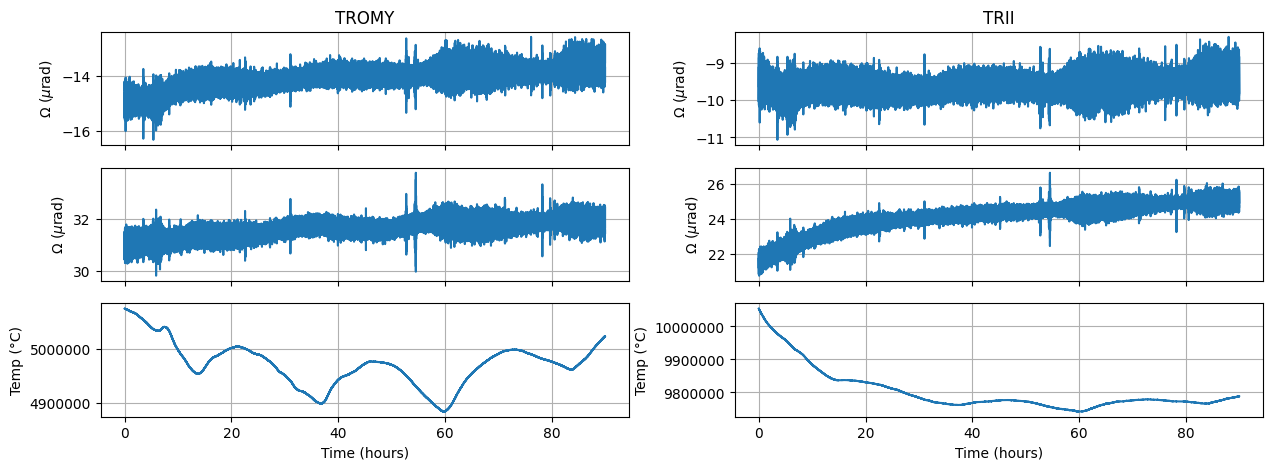

In [11]:
fig = __makeplot(TROMY, TRII, config);

### Comparison

In [12]:
from andbro__crosscorrelation import __crosscorrelation

In [13]:
t1 = UTCDateTime("2022-04-10 06:00")
t2 = config.get('tend')

TROMY_select = TROMY.copy()
TRII_select  = TRII.copy()

TROMY_select.trim(t1, t2)
TRII_select.trim(t1, t2)

TROMY_select.detrend('demean')
TRII_select.detrend('demean')

TROMY_select.taper(0.1)
TRII_select.taper(0.1)

TROMY_select.filter("bandpass", freqmin=0.0001, freqmax=0.1, corners=4, zerophase=True)
TRII_select.filter("bandpass", freqmin=0.0001, freqmax=0.1, corners=4, zerophase=True)

TROMY_select.normalize()
TRII_select.normalize()

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAN | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAT | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TRII..MAE | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAN | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAT | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAN | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAT | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TRII..MAE | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAN | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAT | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAN | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAT | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TRII..MAE | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAN | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAT | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAN | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAT | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TRII..MAE | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAN | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAT | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAN | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples
BW.TROMY..MAT | 2022-04-10T06:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 972001 samples

3 Trace(s) in Stream:
BW.TRII..MAE | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAN | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples
BW.TRII..MAT | 2022-04-10T05:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 972001 samples

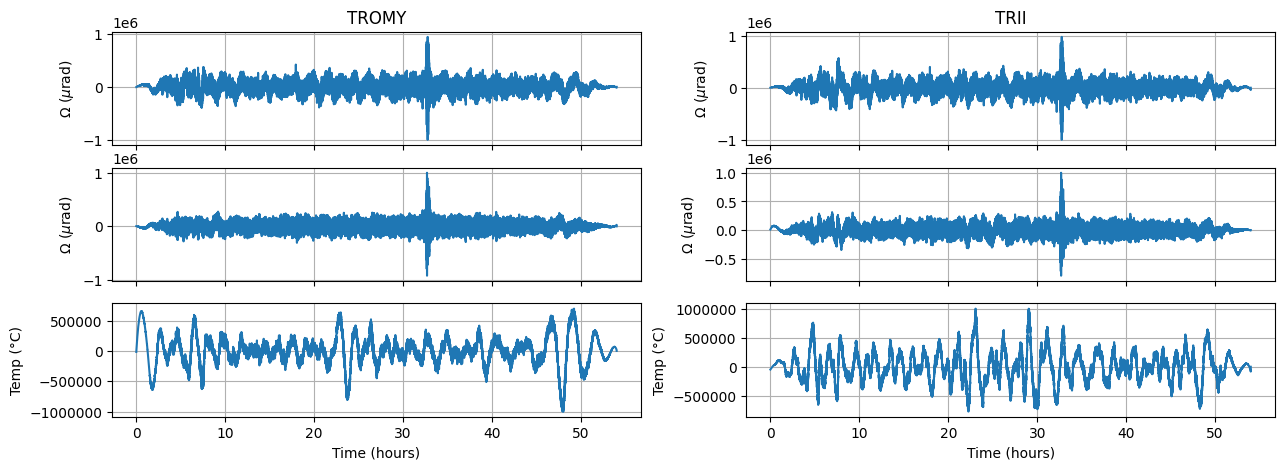

In [14]:
fig = __makeplot(TROMY_select, TRII_select, config);

1


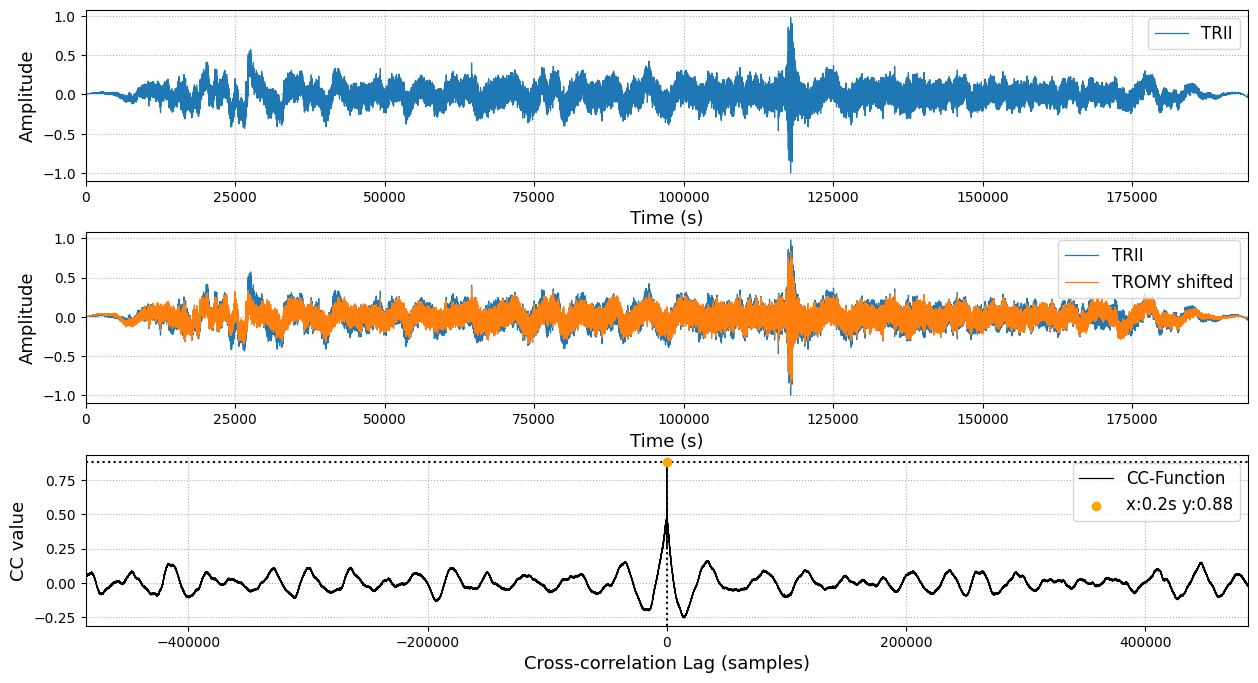

Maximum Correlation: 
 x: 1 
 y: 0.88


In [15]:
__crosscorrelation(TRII_select[0].data, 
                   TROMY_select[0].data, 
                   plot=True, 
                   deltaT=TROMY_select[0].stats.delta, 
                   labels=['TRII', 'TROMY']);

0


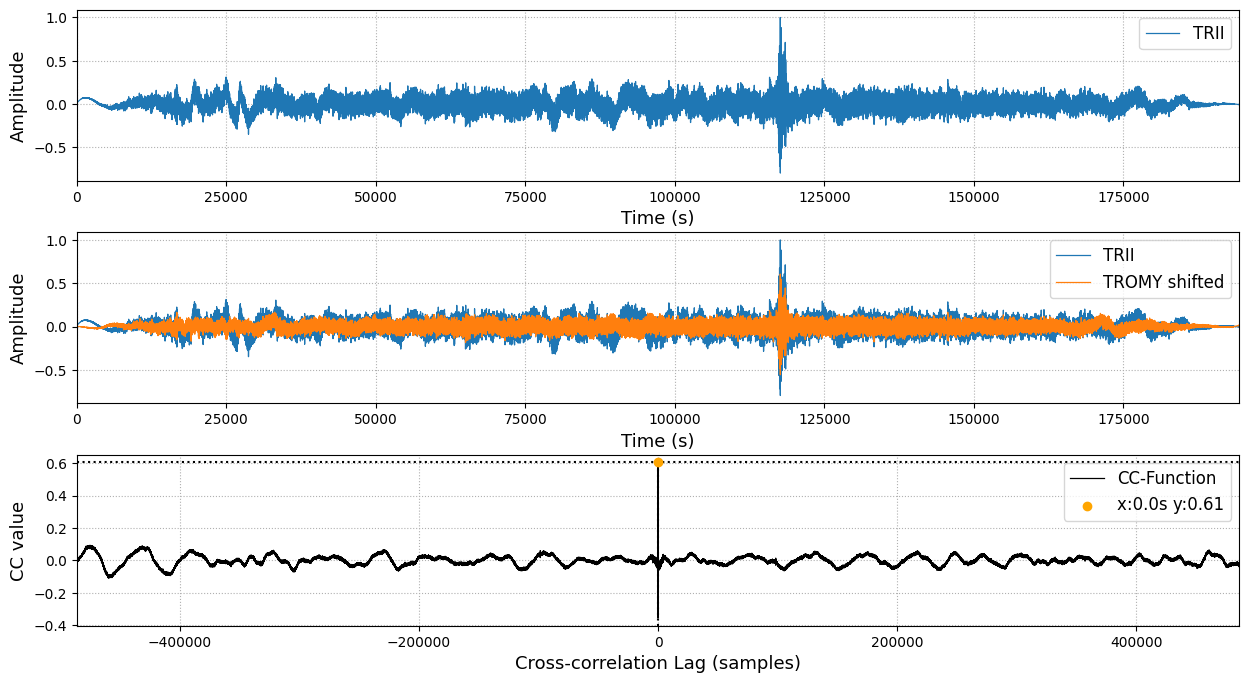

Maximum Correlation: 
 x: 0 
 y: 0.61


In [16]:
__crosscorrelation(TRII_select[1].data, 
                   TROMY_select[1].data,
                   plot=True, 
                   deltaT=TROMY_select[0].stats.delta, 
                   labels=['TRII', 'TROMY']);

### Plot Spectra

In [17]:
st_new = obspy.Stream()

st_new += TRII.copy().select(channel="*N")
st_new += TRII.copy().select(channel="*E")

st_new += TROMY.copy().select(channel="*N")
st_new += TROMY.copy().select(channel="*E")

In [18]:
st_new.detrend("simple")
st_new.taper(0.2)

st_new.filter("bandpass", freqmin=1/(86400), freqmax=0.01, corners=4, zerophase=True)

4 Trace(s) in Stream:
BW.TRII..MAN  | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TRII..MAE  | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAN | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAE | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples

4 Trace(s) in Stream:
BW.TRII..MAN  | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TRII..MAE  | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAN | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAE | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples

4 Trace(s) in Stream:
BW.TRII..MAN  | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TRII..MAE  | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAN | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAE | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples

In [19]:
def __makeplotStreamSpectra(st, config):

    from scipy import fftpack
    from numpy import abs

    NN = len(st)

    fig, axes = plt.subplots(NN,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        comp_fft = abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                    ff[1:len(ff)//2],
                    fxx,
                    color='black',
                    lw=1.0,
                    )
        
        axes[i,1].vlines(1/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400, min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
                      
        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')    
        axes[i,1].set_ylabel(r'ASD (rad/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#         axes[i,1].set_xlim(1e-5, 0.001)
#         axes[i,1].set_ylim(0,max(fxx[200:]))

    return fig

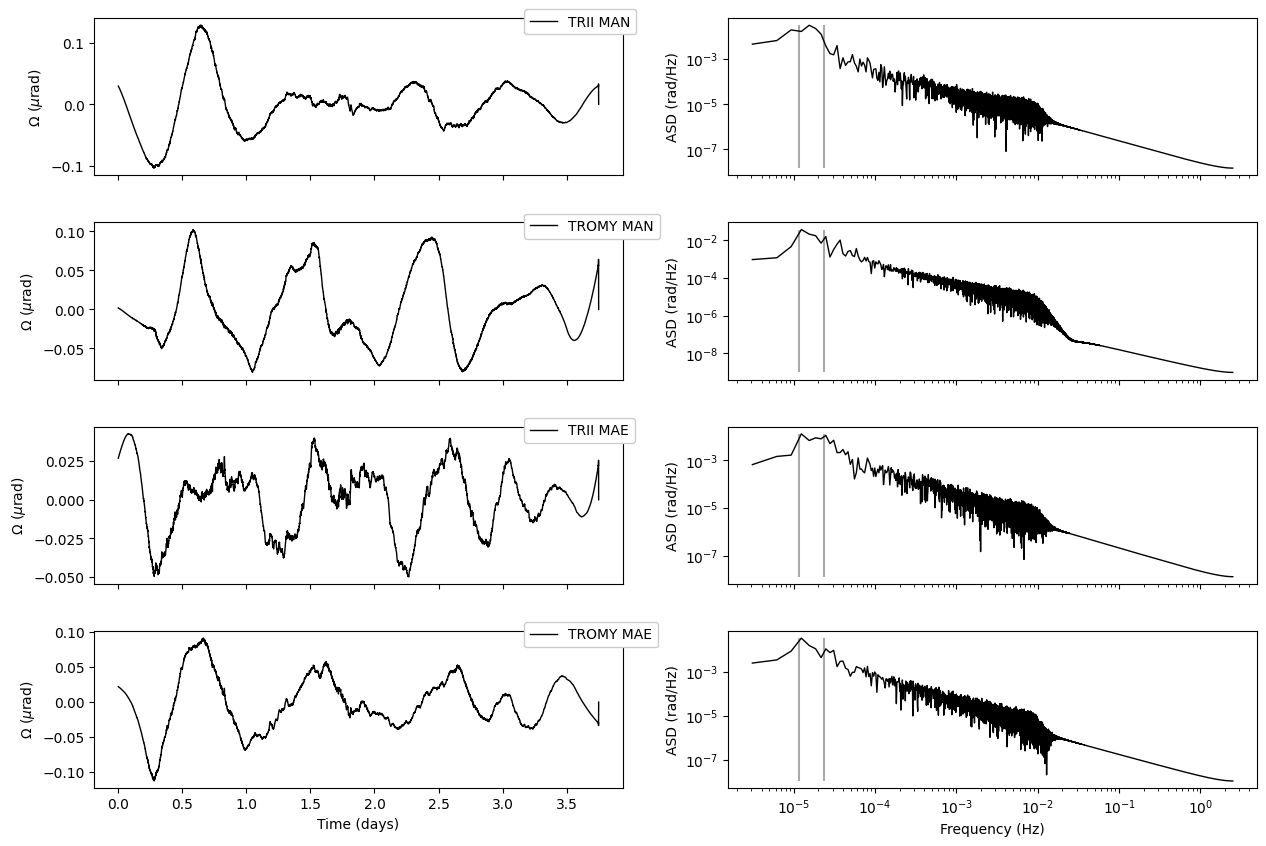

In [20]:
__makeplotStreamSpectra(st_new, config);

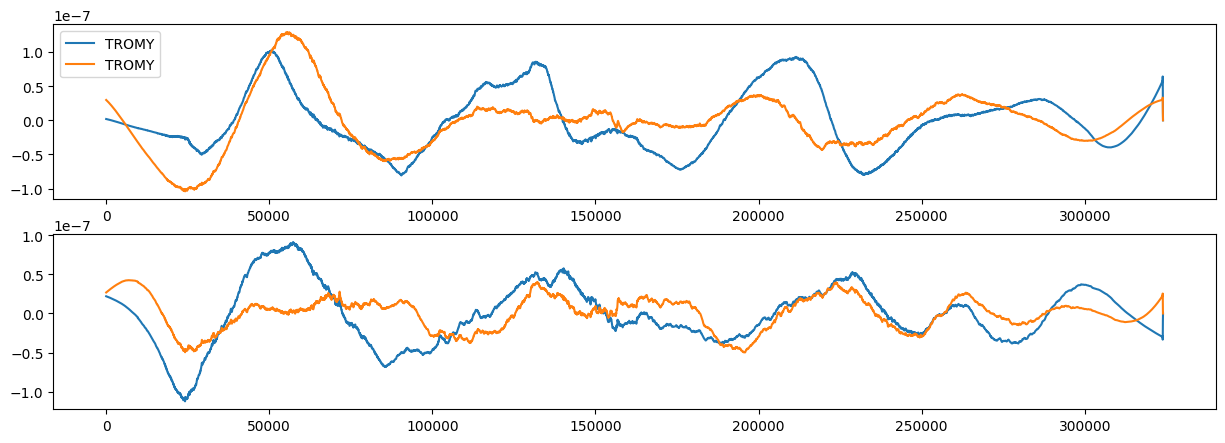

In [21]:
def __makeplot_trace_compare(st):
    
    fig, ax = plt.subplots(2,1, figsize=(15,5))
    
    ax[0].plot(st.select(station="TROMY", channel="*N")[0].times(), st.select(station="TROMY", channel="*N")[0].data, label="TROMY")
    ax[0].plot(st.select(station="TRII", channel="*N")[0].times(), st.select(station="TRII", channel="*N")[0].data, label="TROMY")
    
    ax[1].plot(st.select(station="TROMY", channel="*E")[0].times(), st.select(station="TROMY", channel="*E")[0].data, label="ROMYT")
    ax[1].plot(st.select(station="TRII", channel="*E")[0].times(), st.select(station="TRII", channel="*E")[0].data, label="ROMYT")
        
    ax[0].legend()
    ax[0].legend()
    
__makeplot_trace_compare(st_new)
    

In [22]:
st_new

4 Trace(s) in Stream:
BW.TRII..MAN  | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAN | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples
BW.TRII..MAE  | 2022-04-08T17:59:59.940000Z - 2022-04-12T11:59:59.940000Z | 5.0 Hz, 1620001 samples
BW.TROMY..MAE | 2022-04-08T18:00:00.040000Z - 2022-04-12T12:00:00.040000Z | 5.0 Hz, 1620001 samples

108958


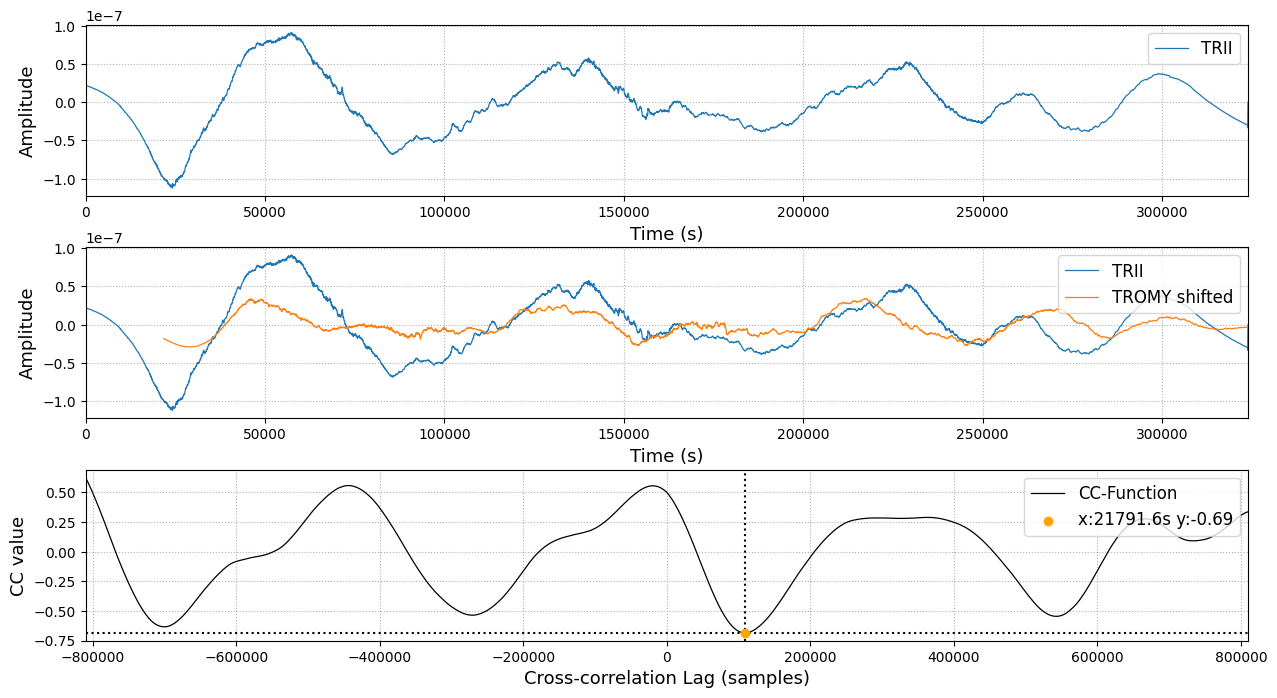

Maximum Correlation: 
 x: 108958 
 y: -0.69


In [23]:
__crosscorrelation(st_new.select(station="TROMY", channel="*E")[0].data, 
                   st_new.select(station="TRII", channel="*E")[0].data,
                   plot=True, 
                   deltaT=st_new[0].stats.delta, 
                   labels=['TRII', 'TROMY']);

## Tests

In [ ]:
import numpy as np

from obspy.signal.tf_misfit import plot_tfr

dt = TROMY_select[0].stats.delta
fmin = 0.0001
fmax = 0.1

signal = TROMY_select[0].data

plot_tfr(signal, dt=dt, fmin=fmin, fmax=fmax)

In [ ]:
from scipy.signal import hilbert
from obspy.signal.tf_misfit import plot_tf_misfits

# amplitude and phase error
phase_shift = 0.1
amp_fac = 1.1

# reference signal
st2 = st1.copy()

# generate analytical signal (hilbert transform) and add phase shift
st1p = hilbert(st1)
st1p = np.real(np.abs(st1p) * \
        np.exp((np.angle(st1p) + phase_shift * np.pi) * 1j))

# signal with amplitude error
st1a = st1 * amp_fac

plot_tf_misfits(st1a, st2, dt=dt, fmin=fmin, fmax=fmax, show=False)
plot_tf_misfits(st1p, st2, dt=dt, fmin=fmin, fmax=fmax, show=False)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt


tr = TROMY[0]
npts = tr.stats.npts
dt = tr.stats.delta
t = np.linspace(0, dt * npts, npts)
f_min = 0.01
f_max = 0.1

scalogram = cwt(tr.data, dt, 8, f_min, f_max)



fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(t, np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
ax.set_xlabel("Time after %s [s]" % tr.stats.starttime)
ax.set_ylabel("Frequency [Hz]")
ax.set_yscale('log')
ax.set_ylim(f_min, f_max)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import mlpy
except ModuleNotFoundError:
    import warnings
    warnings.warn("mlpy not installed, code snippet skipped")
    exit(1)

import obspy

from obspy.imaging.cm import obspy_sequential



tr = obspy.read("https://examples.obspy.org/a02i.2008.240.mseed")[0]

omega0 = 8
wavelet_fct = "morlet"
scales = mlpy.wavelet.autoscales(N=len(tr.data), dt=tr.stats.delta, dj=0.05,
                                 wf=wavelet_fct, p=omega0)
spec = mlpy.wavelet.cwt(tr.data, dt=tr.stats.delta, scales=scales,
                        wf=wavelet_fct, p=omega0)
# approximate scales through frequencies
freq = (omega0 + np.sqrt(2.0 + omega0 ** 2)) / (4 * np.pi * scales[1:])

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
ax1.plot(t, tr.data, 'k')

img = ax2.imshow(np.abs(spec), extent=[t[0], t[-1], freq[-1], freq[0]],
                 aspect='auto', interpolation='nearest', cmap=obspy_sequential)
# Hackish way to overlay a logarithmic scale over a linearly scaled image.
twin_ax = ax2.twinx()
twin_ax.set_yscale('log')
twin_ax.set_xlim(t[0], t[-1])
twin_ax.set_ylim(freq[-1], freq[0])
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)

fig.colorbar(img, cax=ax3)

plt.show()